In [1]:
%load_ext autoreload
%autoreload 2

# Question 1

From the defination of MCL, we have $w_{t}^{[m]}$ is the importance weight which can be noted as $w_{t}^{[m]}=p(z_{t}|x_{t}^{[m]})$  and $x_t^{[m]}$ is sampled from $p(x_t | x_{t-1}^{[m]},u_t)$.

We denote $W_t$ as a continuous,  $x_t$ and $w_t$ are the continuous variables of $w_{t}^{[m]}$ and $x_t^{[m]}$.

Since $x_t^{[m]}$ is sampled from $p(x_t | x_{t-1}^{[m]}, u_t)$, we can write:
$$
p(x_t | z_{1:t-1}, u_{1:t}) = \int p(x_t | x_{t-1}, u_t) p(x_{t-1} | z_{1:t-1}, u_{1:t-1}) dx_{t-1}
$$
Because we propagated the distribution of $x_{t-1}^{[m]}$ through time up to $x_t^{[m]}$,  we can draw $x_t$ from the distribution $p(x_t | z_{1:t-1}, u_{1:t})$ So, refer to Monte Carlo Method $\mathbb{E}[f(x)]=\int f(x)p(x)\,d x$, we have:
$$
\begin{aligned}
\mathbb{E}[W_t]&=\int w_tp(x_t)dx_t\\
&=\int p(z_t | x_t)p(x_t | z_{1:t-1}, u_{1:t}) dx_t\\
&= p(z_t | z_{1:t-1}, u_{1:t})
\end{aligned}
$$
By the strong law of large numbers, 
$$
\operatorname*{lim}_{M\rightarrow+\infty} \frac{1}{M} \Sigma_{m=0}^{M} w_{t}^{[m]} = \mathbb{E}[w_{t}] = p(z_{t}\mid z_{1;t-1},u_{1;t}) \quad
$$


# Question 2&3

In [2]:

import os
import yaml
import random
import time
import math

import numba
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from numba import jit, prange
from tqdm import tqdm
from PIL import Image
from scipy.stats import norm
from bagpy import bagreader

In [3]:
"""
Run which location Mehthod
"""

MCL = False
KLD = True
SAVE_GIF = True

## Preprocess

### Load data

In [4]:
b = bagreader("data\hw2_data.bag")
b.topic_table

[INFO]  Data folder data\hw2_data already exists. Not creating.


,Topics,Types,Message Count,Frequency
0,/odom,nav_msgs/Odometry,1508,21.648803
1,/scan,sensor_msgs/LaserScan,554,7.361928


In [5]:
b = bagreader("data\hw2_data.bag")
df_odom = pd.read_csv(b.message_by_topic('/odom'))
df_scan = pd.read_csv(b.message_by_topic('/scan'))

[INFO]  Data folder data/hw2_data already exists. Not creating.


In [6]:
with open('config.yaml', 'r') as file:
    config = yaml.safe_load(file)
    
print(config)

{'particle_num': 5000, 'ray_num': 120, 'occ_threshold': 220, 'min_odom_distance': 0.2, 'min_odom_angle': 20, 'rot2rot_noise': 0.05, 'trans2rot_noise': 0.05, 'trans2trans_noise': 0.02, 'rot2trans_noise': 0.05, 'z_hit': 100, 'z_short': 10, 'z_max': 10, 'z_rand': 50, 'sigma_hit': 50, 'lambda_short': 20, 'image_resolution': 0.05, 'image_width': 300, 'image_height': 300, 'map_center': {'x': 0, 'y': 2}, 'tf_laser2robot': {'rows': 4, 'cols': 4, 'dt': 'f', 'data': [-1.0, 0.0, 0.0, 0.2, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, -1.0, 0.0, 0.0, 0.0, 0.0, 1.0]}}


In [7]:
rot2rot_noise = config["rot2rot_noise"]
trans2rot_noise = config["trans2rot_noise"]
rot2trans_noise = config["rot2trans_noise"]
trans2trans_noise = config["trans2trans_noise"]
ray_num = config["ray_num"]
z_hit = config["z_hit"]
z_rand = config["z_rand"] 
z_max = config["z_max"]
sigma_hit = config["sigma_hit"]
lambda_short = config["lambda_short"]
z_short = config["z_short"]
particle_num = config["particle_num"]

min_odom_distance = config["min_odom_distance"]
min_odom_angle = config["min_odom_angle"]
map_center_x = config["map_center"]["x"]
map_center_y = config["map_center"]["y"]
image_width = config["image_width"]
image_resolution = config["image_resolution"]
tf_laser2robot = config["tf_laser2robot"]["data"]

### Odom Preprocessing

1508


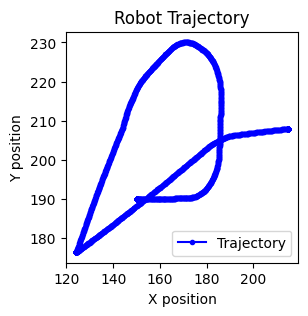

In [8]:
# Process odom data to get np.array([[x, y theta]...])
def quaternion_to_euler(x, y, z, w):
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

# Convert quaternion to euler angles and keep only the angle around Z-axis
df_odom['theta'] = df_odom.apply(lambda row: quaternion_to_euler(row['pose.pose.orientation.x'], 
                                                       row['pose.pose.orientation.y'],
                                                       row['pose.pose.orientation.z'],
                                                       row['pose.pose.orientation.w'])[2], axis=1)
df_odom["pose.pose.position.x"] = (df_odom["pose.pose.position.x"] + map_center_x + (image_width * image_resolution) / 2) / image_resolution
df_odom["pose.pose.position.y"] = (df_odom["pose.pose.position.y"] + map_center_y + (image_width * image_resolution) / 2) / image_resolution


# Create the list with the desired format
df_pose = df_odom[['header.stamp.secs', 'header.stamp.nsecs', 'pose.pose.position.x', 'pose.pose.position.y', 'theta']]
result_list = df_pose.values.tolist()

# Visualize
print(len(result_list))
x_coords = np.array(result_list)[:, 2]
y_coords = np.array(result_list)[:, 3]
plt.figure(figsize=(3, 3))
plt.plot(x_coords, y_coords, label='Trajectory', color='blue', marker='.')
plt.legend()
plt.title('Robot Trajectory')
plt.xlabel('X position')
plt.ylabel('Y position')
plt.show()

robot_poses = result_list

### Scan Preprocessing

In [9]:
# Substract the needed Scan data (ranges, later to get timestamp and intensities )
interval = len(df_scan.filter(regex='^ranges_').columns) // ray_num

sample_indices = np.linspace(0, len(df_scan.filter(regex='^ranges_').columns) - 1, ray_num).astype(int)
ranges_sampled = df_scan.filter(regex='^ranges_').iloc[:, sample_indices]
ranges_sampled[0:5]

,ranges_0,ranges_3,ranges_6,ranges_9,ranges_12,ranges_15,ranges_18,ranges_21,ranges_24,ranges_27,...,ranges_331,ranges_334,ranges_337,ranges_340,ranges_343,ranges_346,ranges_349,ranges_352,ranges_355,ranges_359
0,inf,3.250,2.841,2.921,3.172,3.325,3.503,3.427,3.362,3.278,...,inf,4.561,4.698,6.161,6.312,5.932,5.706,5.512,inf,inf
1,inf,inf,2.822,2.873,3.145,3.335,inf,3.396,3.353,3.280,...,inf,4.549,4.698,6.146,6.267,5.905,5.706,5.568,inf,inf
2,3.413,3.251,3.176,2.919,3.154,3.368,inf,inf,3.355,3.284,...,inf,4.574,4.761,6.237,6.215,5.915,5.710,5.556,inf,inf
3,inf,inf,3.170,inf,3.142,3.355,inf,3.396,3.358,3.287,...,inf,4.549,4.761,6.234,6.252,5.902,5.747,5.553,7.700,inf
4,3.401,3.246,3.172,2.927,3.162,3.357,3.535,inf,3.355,3.274,...,inf,4.567,4.759,6.282,6.252,5.922,5.725,5.562,7.208,inf


In [10]:
# Transfer scan data to robot frame
tf_laser2robot = np.array([[-1.0, 0.0, 0.0, 0.2], 
                           [0.0, 1.0, 0.0, 0.0], 
                           [0.0, 0.0, -1.0, 0.0], 
                           [0.0, 0.0, 0.0, 1.0]])


def transform_scan_data(df_scan, angle_increment, ray_num, sample_indices, tf_laser2robot):
    tf_distance = []
    
    for i in range(ray_num): 
        angle = angle_increment * i
        distance = df_scan[f'ranges_{sample_indices[i]}']
        if distance == np.inf:
            tf_distance.append(np.inf)
        else:
            x_laser = distance * np.cos(angle)
            y_laser = distance * np.sin(angle)
            # print(x_laser, y_laser)
            # Apply Transformation
            point_laser_hom = np.array([x_laser, y_laser, 0, 1])
            point_robot_hom = np.dot(tf_laser2robot, point_laser_hom)
            tf_distance.append(np.linalg.norm(point_robot_hom[:2]))
    return np.array(tf_distance)


transformed_ranges_sampled = []

for index, row in ranges_sampled.iterrows():
    transformed_scan_points = transform_scan_data(row, df_scan["angle_increment"][index], ray_num, sample_indices, tf_laser2robot)
    transformed_ranges_sampled.append(transformed_scan_points)

col_names = [f'ranges_{i}' for i in sample_indices]
transformed_ranges_sampled = pd.DataFrame(transformed_ranges_sampled, columns=col_names)
transformed_ranges_sampled[0:5]

,ranges_0,ranges_3,ranges_6,ranges_9,ranges_12,ranges_15,ranges_18,ranges_21,ranges_24,ranges_27,...,ranges_331,ranges_334,ranges_337,ranges_340,ranges_343,ranges_346,ranges_349,ranges_352,ranges_355,ranges_359
0,inf,3.050032,2.641131,2.721294,2.97252,3.125810,3.304162,3.228583,3.164069,3.080621,...,inf,4.636435,4.776522,6.241862,6.395957,6.019254,5.796462,5.605631,inf,inf
1,inf,inf,2.622131,2.673294,2.94552,3.135810,inf,3.197584,3.155069,3.082621,...,inf,4.624444,4.776522,6.226868,6.350976,5.992266,5.796462,5.661603,inf,inf
2,3.213,3.051032,2.976130,2.719294,2.95452,3.168809,inf,inf,3.157069,3.086621,...,inf,4.649424,4.839476,6.317829,6.298998,6.002261,5.800460,5.649609,inf,inf
3,inf,inf,2.970130,inf,2.94252,3.155809,inf,3.197584,3.160069,3.089621,...,inf,4.624444,4.839476,6.314831,6.335982,5.989267,5.837443,5.646611,7.795894,inf
4,3.201,3.046033,2.972130,2.727294,2.96252,3.157809,3.336161,inf,3.157069,3.076621,...,inf,4.642430,4.837477,6.362810,6.335982,6.009258,5.815453,5.655606,7.304030,inf


In [11]:
intensities_sampled = df_scan.filter(regex='^intensities_').iloc[:, sample_indices]

# 将header.stamp.secs, header.stamp.nsecs, sampled ranges和sampled intensities合并到一个列表中
robot_scans = df_scan[['header.stamp.secs', 'header.stamp.nsecs']].join([transformed_ranges_sampled, intensities_sampled]).values.tolist()

In [12]:
# Match the closest scan for each Odom, with the same second and the closest nanosecond
def find_closest_time(robot_pose_item, robot_scan):
    pose_secs = robot_pose_item[0]
    pose_nsecs = robot_pose_item[1]
        
    min_time_diff = float('inf')
    closest_result = None
    
    for result_item in robot_scan:
        result_secs = result_item[0]
        result_nsecs = result_item[1]
        
        if pose_secs == result_secs:
            time_diff = abs(pose_nsecs - result_nsecs)
            if time_diff < min_time_diff:
                min_time_diff = time_diff
                closest_result = result_item
    
    return closest_result

matched_scans = []
for robot_pose in robot_poses:
    closest_result = find_closest_time(robot_pose, robot_scans)
    if closest_result:
        matched_scans.append(closest_result)

pd.DataFrame(matched_scans)[0:5]

,0,1,2,3,4,5,6,7,8,9,...,232,233,234,235,236,237,238,239,240,241
0,1.552909e+09,744744980.0,inf,inf,2.622131,2.673294,2.94552,3.135810,inf,3.197584,...,0.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,0.0,0.0
1,1.552909e+09,744744980.0,inf,inf,2.622131,2.673294,2.94552,3.135810,inf,3.197584,...,0.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,0.0,0.0
2,1.552909e+09,744744980.0,inf,inf,2.622131,2.673294,2.94552,3.135810,inf,3.197584,...,0.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,0.0,0.0
3,1.552909e+09,872782736.0,3.213,3.051032,2.976130,2.719294,2.95452,3.168809,inf,inf,...,0.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,0.0,0.0
4,1.552909e+09,872782736.0,3.213,3.051032,2.976130,2.719294,2.95452,3.168809,inf,inf,...,0.0,47.0,47.0,47.0,47.0,47.0,47.0,47.0,0.0,0.0


In [13]:
"""
Output parameters
"""
sample_indices
angle_increment = df_scan["angle_increment"][0]
robot_poses = np.array(robot_poses)[:,2:]
robot_scans = np.array(matched_scans)[:,2:]

## MCL

### Init Particles

In [14]:
grid_map = np.array(Image.open("data/gridmap.png").convert('L'))

# get the non-occupied indices by the threshold
free_space_indices = np.where(grid_map > config['occ_threshold'])

# randomly select particle_num particles from the free space
particle_indices = np.random.choice(len(free_space_indices[0]), config['particle_num'])
particles = np.array(list(zip(
    free_space_indices[1][particle_indices], 
    free_space_indices[0][particle_indices], 
    np.random.uniform(-np.pi, np.pi, config['particle_num']),
    )))

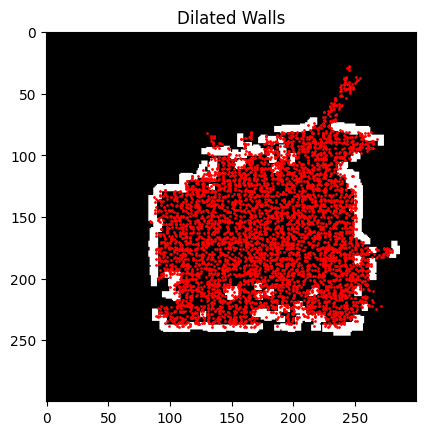

In [15]:
wall_map = np.where(grid_map == 0, 255, 0).astype(np.uint8)

kernel = np.ones((5, 5), np.uint8)
wall_map = np.array(cv2.dilate(wall_map, kernel, iterations=1))

plt.imshow(wall_map, cmap='gray')
plt.scatter(particles[:, 0], particles[:, 1], color='red', s=1)

plt.title('Dilated Walls and Particles')
plt.show()

In [16]:
"""
Output parameters
"""
sample_indices
# robot_poses = robot_poses[0:200, :]
# robot_scans = robot_scans[0:200, :]
print(particles.shape, wall_map.shape, robot_poses.shape, robot_scans.shape)

(5000, 3) (300, 300) (1508, 3) (1508, 240)


### Senor and Motion

-152.67418367275516


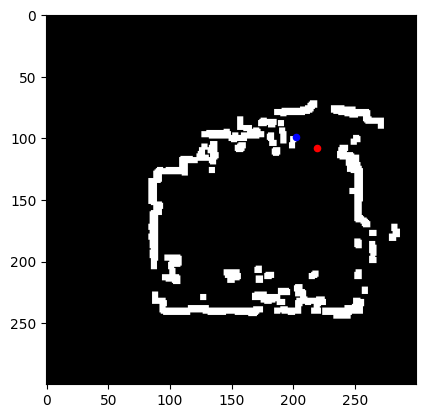

In [17]:
"""
Helper functions
"""

@jit(nopython=True)
def ray_cast(x, y, theta, occlusions: np.ndarray):
    """
    Cast a ray from (x, y) in the direction of theta and return the distance to the nearest obstacle.
    """
    # Convert the angle to a unit vector
    dx = np.cos(theta)
    dy = np.sin(theta)
    
    distance = 0.0
    step_size = 1.0
    # Check each point along the ray
    while True:
        # Move along the ray
        x += dx * step_size
        y += dy * step_size
        distance += step_size
        # Check if the ray has gone out of bounds
        if not (0 <= x < occlusions.shape[0] and 0 <= y < occlusions.shape[1]):
            return int(x), int(y), distance
        # Get the coordinates of the current point on the ray
        ray_x = int(x)
        ray_y = int(y)
        
        # Check if we hit an obstacle
        if occlusions[ray_y, ray_x] == 255:
            return ray_x, ray_y, distance


position_x, position_y, rotation = particles[np.random.choice(particles.shape[0])]
print(np.rad2deg(rotation))
x, y, _ = ray_cast(position_x, position_y, rotation, wall_map)
plt.imshow(wall_map, cmap='gray')
plt.scatter(position_x,position_y, color='red', s=20)
plt.scatter(x, y, color='blue', s=20)
plt.show()

In [18]:
"""
accelerate part
"""

@jit(nopython=True)
def sensor_model(distance, z_exp, z_hit, z_rand, z_max, sigma_hit, lambda_short, z_short):
    """
    Compute the weight for a Ray based on the sensor model.
    """
    # The hit component (Gaussian)
    hit_prob = (1 / (sigma_hit * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((distance - z_exp) ** 2) / (sigma_hit ** 2))
    
    # The random component
    rand_prob = 1.0 / z_max
    
    # The max component
    max_prob = 1.0 if distance >= z_max else 0.0
    
    # The short component (Exponential)
    if distance < z_exp:
        short_prob = lambda_short * np.exp(-lambda_short * distance)
    else:
        short_prob = 0.0
    
    # Calculate the final weight combining all components
    weight = (z_hit * hit_prob + z_rand * rand_prob + z_max * max_prob + z_short * short_prob)
    return weight

@jit(nopython=True)
def motion_model(old_pose, control):
    """
    Apply the motion model to update the particle's pose based on control input.
    """
    global rot2rot_noise, trans2trans_noise, trans2rot_noise, rot2trans_noise
    
    x, y, theta = old_pose
    delta_rot1, delta_trans, delta_rot2 = control

    # Apply the motion model with noise
    delta_rot1_hat = delta_rot1 - random.gauss(0.0, rot2rot_noise * abs(delta_rot1) + trans2rot_noise * abs(delta_trans))
    delta_trans_hat = delta_trans - random.gauss(0.0, trans2trans_noise * abs(delta_trans) + rot2trans_noise * abs(delta_rot1 + delta_rot2))
    delta_rot2_hat = delta_rot2 - random.gauss(0.0, rot2rot_noise * abs(delta_rot2) + trans2rot_noise * abs(delta_trans))

    x += delta_trans_hat * math.cos(theta + delta_rot1_hat)
    y += delta_trans_hat * math.sin(theta + delta_rot1_hat)
    theta += delta_rot1_hat + delta_rot2_hat

    return np.array([x, y, theta])

@jit(nopython=True, parallel=True)
def move_particles(particles_, control):
    """
    Get the moved particles
    """
    length = particles_.shape[0]
    moved_particles = np.zeros_like(particles_)
    for index in prange(length):
        moved_particles[index] = motion_model(particles_[index], control)    
    return moved_particles


@jit(nopython=True)
def ray_casting_sensor_model(pose, scan):
    """
    Compute the weight for a particle based on the sensor model.
    """
    global wall_map
    x, y, theta = pose
    weight = 1.0

    # Cast rays and compute weight based on sensor model
    for i in range(ray_num):
        if scan[ray_num+i] == 0:
            continue
        z_exp = scan[i]
        angle = theta + (-np.pi + sample_indices[i]*angle_increment)
        _, _, distance = ray_cast(x, y, angle, wall_map)            
        weight *= sensor_model(distance, z_exp, z_hit, z_rand, z_max, sigma_hit, lambda_short, z_short)

    return weight

@jit(nopython=True, parallel=True)
def get_weights(particles_, scan):
    """
    Get a weights array for all particles
    """
    length = particles_.shape[0]
    weights = np.zeros(length)
    for index in prange(length):
        weights[index] = ray_casting_sensor_model(particles_[index], scan)
    return weights


# @jit(nopython=True)
def resample(particles_, weights):
    """
    Resample the particles based on their weights.
    """
    indices = np.random.choice(np.arange(len(particles_)), size=particle_num, p=weights/np.sum(weights), replace=True)
    resampled_particles = particles_[indices]
        
    return resampled_particles

In [19]:
"""
Main loop
"""

sensor_time = 0
motion_time = 0
resample_time = 0

def visualize_localization(index, particles_, base_path):
    global wall_map
    if not os.path.exists(base_path):
        os.mkdir(base_path)
    if index % 10 == 1:
        plt.figure(figsize=(5,5))
        plt.imshow(wall_map, cmap='gray')
        plt.scatter(particles_[:, 0], particles_[:, 1], color='red', s=1)
        plt.title('Particle Positions')
        # plt.axis('off')
        plt.savefig(f"{base_path}/test_Step{index}.png")
        plt.close()

def localize(particles_, visualize=True):
    global wall_map, robot_poses, robot_scans, sensor_time, motion_time, resample_time
    assert robot_poses.shape[0] == robot_scans.shape[0]
    # particle_filter = ParticleFilter(map, particles)

    for i in tqdm(range(1, robot_poses.shape[0])):
        # trajectory.append(particles_.tolist()[0])
        if visualize:
            visualize_localization(i, particles_, base_path="output\step_img")
        # Check if the control input meets the minimum condition
        x_hat, y_hat, theta_hat = robot_poses[i-1]
        x_hat_1, y_hat_1, theta_hat_1 = robot_poses[i]
        delta_rot1 = math.atan2(y_hat_1-y_hat, x_hat_1-x_hat) - theta_hat
        delta_trans = math.sqrt((x_hat-x_hat_1)**2 + (y_hat-y_hat_1)**2)
        delta_rot2 = theta_hat_1 - theta_hat - delta_rot1
        control = np.array([delta_rot1, delta_trans, delta_rot2])
        
        if abs(delta_trans) < min_odom_distance and abs(delta_rot1 + delta_rot2) < min_odom_angle * np.pi / 180:
            continue
                
        # Update particle poses based on motion model
        t0 = time.time()
        particles_ = move_particles(particles_, control)
        t1 = time.time()
        motion_time += t1 - t0
        
        weights = get_weights(particles_, robot_scans[i])
        t2 = time.time()
        sensor_time += t2 -t1
        
        particles_ = resample(particles_, weights)
        t3 = time.time()
        resample_time += t3 - t2
    return particles_


In [20]:
%%time

visualize = SAVE_GIF

# MCL = False
if MCL:
    localize(particles, visualize=visualize)
    print(f"[Config] {config}")
    print(f"[Time cost] Move:{motion_time}, Senor:{sensor_time}, resample: {resample_time}")

CPU times: total: 0 ns
Wall time: 0 ns


## KLD

In [21]:
bin_size, bins_per_axis = 0,0
sensor_time = 0
motion_time = 0
resample_time = 0

def kld_sampling_resample(particles_, weights, z, epsilon, delta, bins, min_particles):
    """
    Resample the particles based on their weights using KLD Sampling.
    """
    indices = np.arange(len(particles_))
    resampled_particles = []
    
    M = 0
    k = 0
    bin_counts = np.zeros(bins)
    M_chi = 0
    
    while True:
        M += 1
        index = np.random.choice(indices, p=weights/np.sum(weights))
        selected_particle = particles_[index]
        resampled_particles.append(selected_particle)
        
        bin_index = int(selected_particle[0] // bin_size + (selected_particle[1] // bin_size - 1) * bins_per_axis)
        if bin_counts[bin_index] == 0:
            k += 1
        bin_counts[bin_index] += 1
        
        if k > 2:
            M_chi = (k - 1) / (2 * epsilon) * (1 - 2 / (9 * (k - 1)) + np.sqrt(2 / (9 * (k - 1))) * norm.ppf(1 - delta)) ** 3
        if M >= M_chi and M > min_particles:
            break
            
    return np.array(resampled_particles)

particle_num_list = []

def localize_kld(particles_, epsilon, delta, min_particles, max_particles, bins, visualize=True):
    global wall_map, robot_poses, robot_scans, bin_size, bins_per_axis, motion_time, sensor_time, resample_time
    assert robot_poses.shape[0] == robot_scans.shape[0]
    
    bins_per_axis = int(math.sqrt(bins))
    bin_size = wall_map.shape[0] / bins_per_axis
    
    for i in tqdm(range(1, robot_poses.shape[0])):
        if visualize:
            visualize_localization(i, particles_, base_path="output\step_img_KLD")
        
        # Motion update (move_particles remains unchanged)
        x_hat, y_hat, theta_hat = robot_poses[i-1]
        x_hat_1, y_hat_1, theta_hat_1 = robot_poses[i]
        delta_rot1 = math.atan2(y_hat_1-y_hat, x_hat_1-x_hat) - theta_hat
        delta_trans = math.sqrt((x_hat-x_hat_1)**2 + (y_hat-y_hat_1)**2)
        delta_rot2 = theta_hat_1 - theta_hat - delta_rot1
        control = np.array([delta_rot1, delta_trans, delta_rot2])

        if abs(delta_trans) < min_odom_distance and abs(delta_rot1 + delta_rot2) < min_odom_angle * np.pi / 180:
            continue
        
        t0 = time.time()
        particles_ = move_particles(particles_, control)
        t1 = time.time()
        motion_time += t1 - t0
        
        weights = get_weights(particles_, robot_scans[i])
        t2 = time.time()
        sensor_time += t2 - t1
        
        # Resample using KLD Sampling
        particle_num_list.append(len(particles_))
        particles_ = kld_sampling_resample(particles_, weights, robot_scans[i], epsilon, delta, bins, min_particles)        
        
        # Ensure that the number of particles stays within min and max bounds
        if len(particles_) < min_particles:
            indices = np.random.choice(np.arange(len(particles_)), size=min_particles - len(particles_))
            additional_particles = particles_[indices]
            particles_ = np.concatenate((particles_, additional_particles))
        elif len(particles_) > max_particles:
            indices = np.random.choice(np.arange(len(particles_)), size=max_particles)
            particles_ = particles_[indices]
        t3 = time.time()
        resample_time += t3 - t2
        
    return particles_

In [22]:
%%time

epsilon = 0.1 
delta = 0.05 
min_particles = 100
max_particles = 5000
bins = 100
visualize = SAVE_GIF


if KLD:
    localize_kld(particles, epsilon, delta, min_particles, max_particles, bins, visualize=visualize)
    print(f"[Time cost] Move:{motion_time}, Senor:{sensor_time}, resample: {resample_time}")

  0%|          | 0/1507 [00:00<?, ?it/s]

100%|██████████| 1507/1507 [00:21<00:00, 68.70it/s] 

[Time cost] Move:1.4237685203552246, Senor:1.695939302444458, resample: 2.8209168910980225
CPU times: total: 1min 28s
Wall time: 21.9 s


## Save Result

In [24]:
from PIL import Image
import re
import os
import time

timestamp = time.strftime("%m%d-%H%M%S", time.localtime())
# remark = f"test_noise{rot2rot_noise},{trans2rot_noise},{trans2trans_noise},{rot2trans_noise}"
remark = ""
task_id = "test-kld"
if remark:
    remark += "_"


def save_gif(image_folder, method, output_path):
    global timestamp, remark
    gif_filename = f'{timestamp}_{method}_{remark}{particle_num}_{ray_num}.gif'

    def sort_key(filename):
        numbers = re.findall(r'\d+', filename)
        return int(numbers[0]) if numbers else 0

    image_files = [os.path.join(image_folder, f) for f in os.listdir(image_folder) if f.endswith('.png')]
    image_files.sort(key=sort_key)

    images = [Image.open(image) for image in image_files]

    images[0].save(os.path.join(output_path, gif_filename), save_all=True, append_images=images[1:], optimize=False, duration=100, loop=0)

if SAVE_GIF:
    if not os.path.exists(f"output/{task_id}"):
        os.mkdir(f"output/{task_id}")
    if MCL:
        method = "MCL"
        save_gif(image_folder=f"output/step_img", method=method, output_path=f"output/{task_id}")
        print(f"[INFO] save {method} result")
    if KLD:
        method = "KLD"
        save_gif(image_folder=f"output/step_img_kld", method=method, output_path=f"output/{task_id}")
        print(f"[INFO] save {method} result")


[INFO] save KLD result


## MISC

In [25]:
# import shutil
# import os

# shutil.rmtree("D:\Courses\CS284-SLAM\slam hw2\HW2\output\step_img")
# os.mkdir("output\step_img")

In [26]:
# import os
# from PIL import Image
# import numpy as np
# import matplotlib.pyplot as plt

# image_folder_path = 'D:\Courses\CS284-SLAM\slam hw2\HW2\output\step_img'
# image_files = [f for f in os.listdir(image_folder_path) if f.endswith('.jpg') or f.endswith('.png')]
# accumulated_image = None

# for image_file in image_files:
#     image_path = os.path.join(image_folder_path, image_file)
#     image = Image.open(image_path)    
#     image_array = np.array(image)
    
#     if accumulated_image is None:
#         accumulated_image = image_array.copy()
#     else:
#         accumulated_image = np.maximum(accumulated_image, image_array)

# final_image = Image.fromarray(accumulated_image)

# plt.imshow(final_image)
# plt.axis('off') 
# plt.show()